NN input shape: (99989, 24)
NN target shape: (99989, 2)


C:\Users\ZYG\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,890 (23.01 KB)

 Trainable params: 5,890 (23.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 554us/step - loss: 0.1287 - val_loss: 0.0019
Epoch 2/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - loss: 0.0013 - val_loss: 3.4012e-04
Epoch 3/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - loss: 2.7666e-04 - val_loss: 1.4095e-04
Epoch 4/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - loss: 1.4581e-04 - val_loss: 1.3992e-04
Epoch 5/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - loss: 1.2704e-04 - val_loss: 1.0544e-04
Epoch 6/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 529us/step - loss: 1.1781e-04 - val_loss: 1.1821e-04
Epoch 7/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 528us/step - loss: 1.0931e-04 - val_loss: 1.1538e-04
Epoch 8/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - loss: 9.9825e-05 - val_loss: 1.1375e-04
Epoch 9/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - loss: 1.0235e-04 - val_loss: 7.6106e-05
Epoch 10/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - loss: 9.2223e-05 - val_loss: 9.9940e-05
Epoch 11/100
2813/281

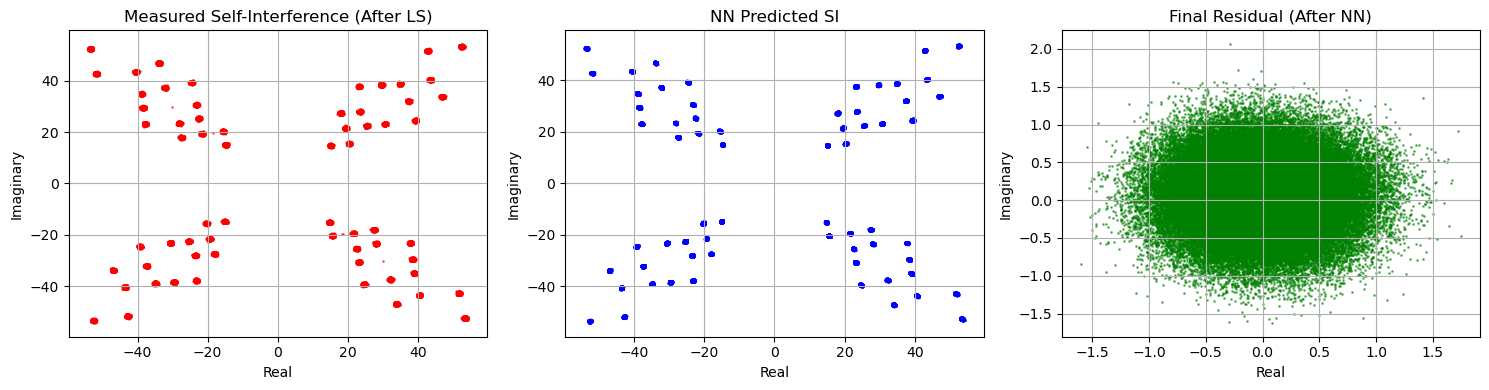

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

#####################################################
# C. NN Nonlinear Stage
#####################################################

def compute_final_icr(rx_signal, y_lin, nn_residual, start_index=0):
    """
    Compute the final Interference Cancellation Ratio (ICR) after nonlinear cancellation.
    """
    rx_part = rx_signal[start_index: start_index + len(nn_residual)]
    lin_part = y_lin[: len(nn_residual)]
    combined = lin_part + nn_residual
    final_res = rx_part - combined
    num = np.sum(np.abs(rx_part)**2)
    den = np.sum(np.abs(final_res)**2)
    icr_db = 10*np.log10(num/den)
    return final_res, icr_db

def complex_vector_to_2d(vc):
    """
    Convert a complex vector (M,) into a (M,2) real array: [Re, Im].
    """
    out = np.zeros((len(vc), 2))
    out[:,0] = vc.real
    out[:,1] = vc.imag
    return out

def build_design_matrix_for_nn(x, L):
    """
    Build the input matrix for the neural network.
    Each row has L consecutive samples, flattening the real & imaginary parts.
    Shape: (N-L+1, 2L)
    """
    N = len(x)
    result = []
    for i in range(N - L + 1):
        window = x[i:i+L]  # Keep original order
        row = np.concatenate([window.real, window.imag])
        result.append(row)
    return np.array(result)

#####################################################
# Load Data and Apply Nonlinear Cancellation
#####################################################

# Load the linear cancellation output
df = pd.read_csv("linear_cancellation_output_100000.csv")

# Extract transmitted and received signal components
tx_signal = df['tx_real'].values + 1j * df['tx_imag'].values
rx_signal = df['si_real'].values + 1j * df['si_imag'].values
y_lin = df['si_est_real'].values + 1j * df['si_est_imag'].values
error = df['residual_real'].values + 1j * df['residual_imag'].values

# Set filter length (L) for nonlinear modeling
L_nn = 12  # Can be adjusted

# Build the input matrix for the neural network
U_nn = build_design_matrix_for_nn(tx_signal, L_nn)
y_nn_target_complex = error[L_nn-1:]

# Ensure dimensions match
if len(U_nn) != len(y_nn_target_complex):
    print(f"Warning: Dimension mismatch: U_nn {len(U_nn)} vs error {len(y_nn_target_complex)}")

# Convert the target to a shape (M,2)
y_nn_target = complex_vector_to_2d(y_nn_target_complex)

print(f"NN input shape: {U_nn.shape}")
print(f"NN target shape: {y_nn_target.shape}")

# Normalize inputs and targets
U_mean = np.mean(U_nn, axis=0)
U_std = np.std(U_nn, axis=0)
U_std[U_std < 1e-12] = 1.0
U_norm = (U_nn - U_mean) / U_std

y_mean = np.mean(y_nn_target, axis=0)
y_std = np.std(y_nn_target, axis=0)
y_std[y_std < 1e-12] = 1.0
y_norm = (y_nn_target - y_mean) / y_std

# Train/validation split
U_train, U_val, y_train, y_val = train_test_split(U_norm, y_norm, test_size=0.1, random_state=42)

#####################################################
# Build and Train the Neural Network
#####################################################

# Define the NN model
model = Sequential()
model.add(InputLayer(input_shape=(U_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

# Model summary
model.summary()

# Train the model
history = model.fit(U_train, y_train, epochs=100, batch_size=32,
                    validation_data=(U_val, y_val), verbose=1)

# Predict nonlinear residual
nn_pred_norm = model.predict(U_norm)  # Shape (M,2)
nn_pred = nn_pred_norm * y_std + y_mean  # Denormalize
nn_pred_complex = nn_pred[:,0] + 1j * nn_pred[:,1]  # Convert to complex

#####################################################
# Compute Final ICR and Save Results
#####################################################

final_res, final_icr = compute_final_icr(rx_signal, y_lin, nn_pred_complex, start_index=L_nn-1)
print(f"Final Interference Cancellation Ratio (ICR): {final_icr:.2f} dB")

#####################################################
# Save the final nonlinear cancellation results
#####################################################
min_len = min(len(tx_signal), len(rx_signal), len(y_lin), len(nn_pred_complex), len(final_res))

tx_signal = tx_signal[:min_len]
rx_signal = rx_signal[:min_len]
y_lin = y_lin[:min_len]
nn_pred_complex = nn_pred_complex[:min_len]
final_res = final_res[:min_len]

output_df = pd.DataFrame({
    'tx_real': tx_signal.real,
    'tx_imag': tx_signal.imag,
    'si_real': rx_signal.real,
    'si_imag': rx_signal.imag,
    'si_est_real': y_lin.real,
    'si_est_imag': y_lin.imag,
    'nn_pred_real': nn_pred_complex.real,
    'nn_pred_imag': nn_pred_complex.imag,
    'final_residual_real': final_res.real,
    'final_residual_imag': final_res.imag
})

# Save the file
output_df.to_csv("FNN_nonlinear_cancellation_output_100000.csv", index=False)
print("Final nonlinear cancellation results saved to FNN_nonlinear_cancellation_output_100000.csv")

#####################################################
# Visualization of Results
#####################################################

plt.figure(figsize=(15, 4))

# 1. Measured Self-Interference (After LS)
plt.subplot(1,3,1)
plt.scatter(error.real, error.imag, s=1, alpha=0.5, color='red')
plt.title("Measured Self-Interference (After LS)")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

# 2. NN Predicted SI
plt.subplot(1,3,2)
plt.scatter(nn_pred_complex.real, nn_pred_complex.imag, s=1, alpha=0.5, color='blue')
plt.title("NN Predicted SI")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

# 3. Final Residual SI
plt.subplot(1,3,3)
plt.scatter(final_res.real, final_res.imag, s=1, alpha=0.5, color='green')
plt.title("Final Residual (After NN)")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

plt.tight_layout()
plt.show()